# Grouping incidents caused by metheorological events

---
### Notebook Sections:


1. Data Cleaning
2. Exploratory Data Analysis
3. Clustering Incidents

### Import modules and functions

In [2]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

### Definir classe 'data' com endereço dos dados
class DATA:
    path = r'C:\Users\luisr\Desktop\Repositories\Dados\Desafio COR-Rio IV\\'
    AlertaAPI = r'http://websempre.rio.rj.gov.br/json/chuvas'

### Load data

In [3]:
catalog = pd.read_csv('dados/incident_catalog.csv', parse_dates=True, infer_datetime_format=True)
catalog = catalog[catalog['POP_TITULO']=="Bolsão d'água em via"].copy()
data = catalog.copy()

---
# Data Cleaning

#### Functions to format street number text variable

In [4]:
def get_not_number(series):
    obj_index = []
    for index, number in zip(series.index, series):
        try:
            a = float(number) + 1
        except:
            obj_index.append(index)
    return series[obj_index]

import string

def drop_letters(text):
    for char in text:
        if char in string.ascii_letters:
            text = text.replace(char, '')
    return text

def drop_space(text):
    return text.replace(' ', '')

def drop_chars(text, chars=['°', 'º']):
    for char in chars:
        text = text.replace(char, '')
    return text

def split_avg(text, seps=['-', '/', ',']):
    if not text:
        return np.nan
    else:
        for sep in seps:
            if sep in text:
                items = [item for item in text.split(sep) if item]
                if len(items)==0:
                    return np.nan
                elif len(items)==1:
                    return items[0]
                else:
                    try:
                        return str(int(np.mean(np.array(items, dtype='int'))))
                    except:
                        return np.nan
        return text

#### Data types

In [144]:
data.dtypes

EVENTO_ID              int64
EVENTO_TITULO         object
EVENTO_DESCRICAO      object
EVENTO_GRAVIDADE      object
EVENTO_BAIRRO         object
STATUS                object
EVENTO_PRAZO          object
POP_TITULO            object
POP_DESCRICAO         object
evento_inicio         object
evento_fim            object
lat                  float64
lng                  float64
formatted_address     object
place_id              object
types                 object
search_lat           float64
search_lng           float64
location_type         object
route                 object
street_number        float64
postal_code           object
premise               object
dtype: object

#### Format and correct street number variable

In [6]:
not_number = get_not_number(catalog['street_number'])
not_number_corrected = not_number.map(drop_letters).map(drop_space).map(drop_chars).map(split_avg)

data.loc[not_number.index, ['street_number']] = not_number_corrected

data.dropna(subset=['street_number'], inplace=True) # drop rows where street number is missing

#### Data type conversion

In [7]:
float_cols = ['lat', 'lng', 'search_lat', 'search_lng', 'street_number']
data[float_cols] = data[float_cols].astype(float)

---
# Exploratory Data Analysis

#### Scatter plot of original coordinates

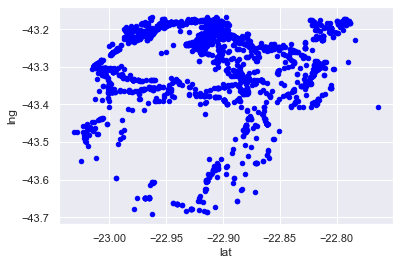

In [147]:
data.plot('lat', 'lng', kind='scatter', c='blue'); plt.show()

#### Incidents per route

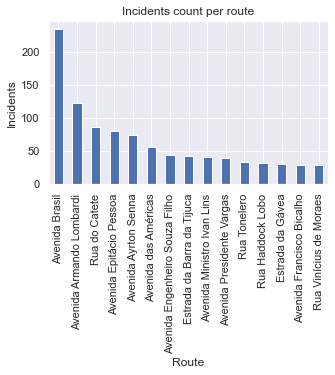

In [140]:
route_count = data['route'].value_counts().rename('Incident count')
fig, ax = plt.subplots(figsize=(5, 3))
route_count.head(15).plot.bar(
    title='Incidents count per route',
)
ax.set(
    ylabel='Incidents',
    xlabel='Route'
)
plt.show()

#### Extracting incidents of routes with at least 'min_incidents' incidents registered

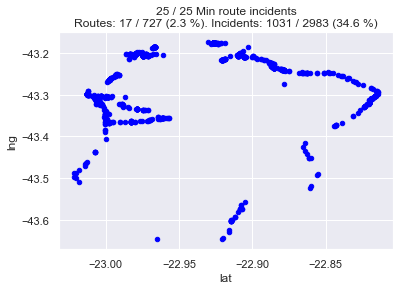

In [116]:
max_incidents = 25
recurrence = []
for min_incidents in range(max_incidents+1):
    rec_routes = route_count[route_count>min_incidents]
    rec_data = data[data['route'].isin(rec_routes.index)]
    
    n_routes = len(rec_routes)
    n_incidents = rec_data.shape[0]
    p_routes = round(n_routes / route_count.shape[0] * 100, 1)
    p_incidents = round(n_incidents / data.shape[0] * 100, 1)
    
    recurrence.append([min_incidents, n_routes, n_incidents, p_routes, p_incidents])
    rec_data.plot(
        'lat', 'lng', kind='scatter', c='blue',
        title=f'{min_incidents} / {max_incidents} Min route incidents\nRoutes: {n_routes} / {route_count.shape[0]} ({p_routes} %). Incidents: {n_incidents} / {data.shape[0]} ({p_incidents} %)',
    )
    plt.show(); plt.pause(.3); co(wait=True)

recurrence_df = pd.DataFrame(recurrence, columns=['min_incidents', 'n_routes', 'n_incidents', 'p_routes', 'p_incidents']); # recurrence_df

#### Percentage of routes and incidents left in top 50 routes

In [117]:
recurrence_df[recurrence_df['n_routes']==50]

,min_incidents,n_routes,n_incidents,p_routes,p_incidents
10,10,50,1546,6.9,51.8


#### Scatter plot of coordinates (colored routes)

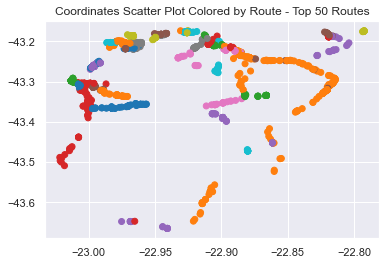

In [150]:
from matplotlib.colors import Colormap
from sklearn.preprocessing import LabelEncoder as le, MinMaxScaler as mms

cmaps = [
    'Pastel1', 'Pastel2', 'Paired', 'Accent',
    'Dark2', 'Set1', 'Set2', 'Set3',
    'tab10', 'tab20', 'tab20b', 'tab20c'
]; cmaps = ['tab10']

min_incidents = 10
rec_routes = route_count[route_count>min_incidents]
rec_data = data[data['route'].isin(rec_routes.index)]

for i in range(len(cmaps)):
    cmap = plt.get_cmap(cmaps[i])
    route_labels = le().fit_transform(rec_data['route'])
    plt.scatter(
        rec_data['search_lat'], rec_data['search_lng'],
        c=route_labels, cmap=cmap,
    )
    plt.title('Coordinates Scatter Plot Colored by Route - Top 50 Routes')
    plt.show()
    if len(cmaps)>1:
        if input(f'\nCmap {i} - {cmaps[i]}. Exit?')=='s': break
    co(wait=True)

#### Street numbers statistical description per route (top 10)

In [127]:
number_desc = rec_data.groupby('route')['street_number'].describe().sort_values('count', ascending=False)
number_desc.head(10)

,count,mean,std,min,25%,50%,75%,max
route,,,,,,,,
Avenida Brasil,235.0,4914.454745,8170.248330,13.0,211.0,500.0,5420.00,35025.0
Avenida Armando Lombardi,123.0,339.861789,430.901577,33.0,188.0,188.0,350.00,3652.0
Rua do Catete,87.0,175.724138,55.524285,1.0,139.0,195.0,228.00,228.0
Avenida Epitácio Pessoa,81.0,1629.308642,1413.060178,5.0,165.0,1612.0,2690.00,4800.0
Avenida Ayrton Senna,74.0,2434.189189,2388.383282,80.0,300.0,2400.0,4581.75,9001.0
Avenida das Américas,57.0,5079.501754,6514.539946,12.3,801.0,2250.0,4444.00,20035.0
Avenida Engenheiro Souza Filho,44.0,1374.454545,801.623018,10.0,586.5,1190.0,2100.00,2631.0
Estrada da Barra da Tijuca,43.0,1426.906977,634.024103,186.0,1030.0,1636.0,1716.00,3163.0
Avenida Ministro Ivan Lins,41.0,749.097561,354.292662,11.0,740.0,850.0,850.00,1770.0


#### Street number ranges description

In [156]:
number_ranges = ( number_desc['max'] - number_desc['min'] ).to_frame('Street numbers range')
number_ranges.describe()

,Street numbers range
count,50.000000
mean,3233.428600
std,6083.758546
min,0.000000
25%,276.500000
50%,1066.000000
75%,2975.654750
max,35012.000000


#### Linear incident density per route statistical description

In [137]:
route_numbers_density = ( route_count / number_ranges * 100 ).sort_values(ascending=False).to_frame('Incidents per 100 m'); route_numbers_density.describe()

,Incidents per 100 m
count,50.000000
mean,inf
std,NaN
min,0.124384
25%,0.972865
50%,2.336738
75%,4.707822
max,inf


In [157]:
density_per_route = route_numbers_density[route_numbers_density.index.isin(rec_routes.index)]

density = pd.concat([density_per_route, rec_routes, number_ranges], 1); density.head(10)

,Incidents per 100 m,Incident count,Street numbers range
Rua 6,inf,18,0.0
Avenida Aquarela do Brasil,inf,11,0.0
Rua do Catete,38.325991,87,227.0
Estrada da Cancela Preta,28.571429,24,84.0
Rua Silveira Martins,16.891892,25,148.0
Rua Vinícius de Moraes,10.104530,29,287.0
Rua Tonelero,10.030395,33,329.0
Rua Haddock Lobo,9.248555,32,346.0
Rua Siqueira Campos,7.971014,11,138.0
Avenida Ernani Cardoso,6.862745,14,204.0


#### Route with smallest incident density in top 50 routes

In [158]:
density.iloc[[49]]

,Incidents per 100 m,Incident count,Street numbers range
Avenida Dom Hélder Câmara,0.124384,12,9647.545


---
# Clustering Incidents

#### Setting automatic clustering algorithms

In [160]:
import sklearn.cluster as cluster
from sklearn.preprocessing import MinMaxScaler as mms, LabelEncoder as le

dbscan = cluster.DBSCAN(0.05)
optics = cluster.OPTICS()
mean = cluster.MeanShift()
aff = cluster.AffinityPropagation()

algs = [dbscan, optics, mean, aff]

### 1. Clustering street numbers

#### Clustering street numbers of routes separatelly

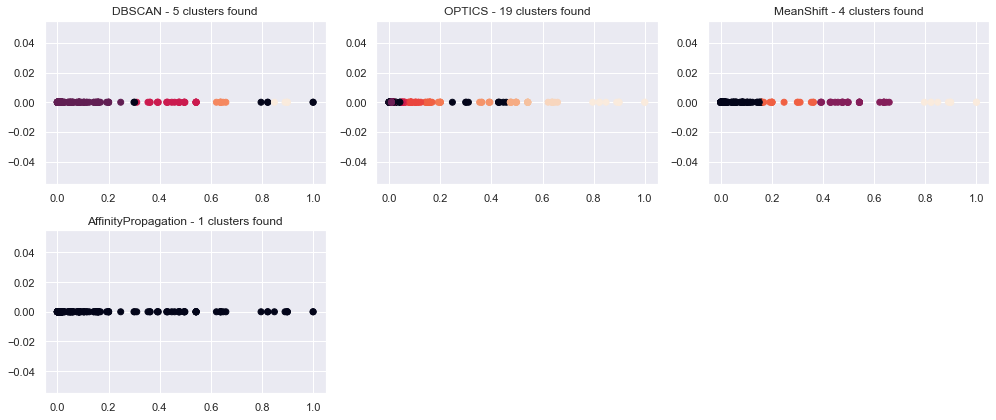

In [166]:
route_numbers = {}
for route in rec_routes.index:
    route_numbers[route] = rec_data.loc[rec_data['route']==route, ['street_number']].dropna().values.tolist()

numbers = mms().fit_transform(route_numbers[route_count.index[0]])

fig = plt.figure(figsize=(14, 6), tight_layout=True)
axs = [fig.add_subplot(2, 3, i) for i in range(1, len(algs)+1)]
for ax, alg in zip(axs, algs):
    alg.fit(numbers)
    ax.scatter(numbers, [0]*len(numbers), c=alg.labels_)
    ax.set(title=f'{type(alg).__name__} - {len(np.unique(alg.labels_))} clusters found')
plt.show()

## 2. Clustering geodetic coordinates

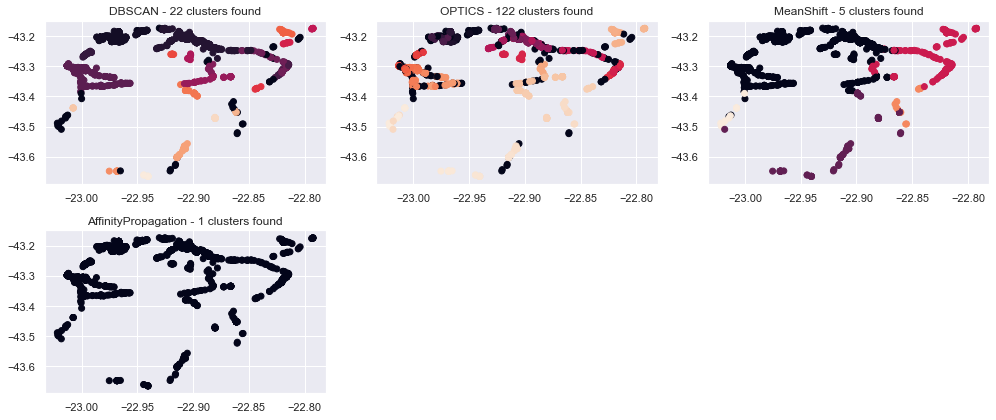

In [167]:
coords = mms().fit_transform(rec_data[['lat', 'lng', 'street_number']])

fig = plt.figure(figsize=(14, 6), tight_layout=True)
axs = [fig.add_subplot(2, 3, i) for i in range(1, len(algs)+1)]
for ax, alg in zip(axs, algs):
    alg.fit(coords)
    ax.scatter(rec_data['lat'], rec_data['lng'], c=alg.labels_)
    ax.set(title=f'{type(alg).__name__} - {len(np.unique(alg.labels_))} clusters found')
plt.show()